# Objectives

Notebook reproducing the plots for figures 4.20 to 4.22 of MSc thesis

Inversion run with SimPEG MagDev_DF branch


In [1]:
from SimPEG import (
    PF, Mesh, Maps, Regularization,
    Optimization, InvProblem, Utils,
    DataMisfit, Directives, Inversion
)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the synthetic data in UBC format
survey, M = PF.Magnetics.readMagneticsObservations("Obs_IND_GRID_TMI.obs")

# Read the mesh in UBC format
mesh = Mesh.TensorMesh.readUBC("Mesh_20m.msh")

# Read in the true model for later comparison
model = Mesh.TensorMesh.readModelUBC(mesh, "Effec_sus_20mGrid.sus")

# Plot the true model

(<matplotlib.collections.QuadMesh at 0x1d89fa34be0>,
 <matplotlib.lines.Line2D at 0x1d89fa34ef0>)

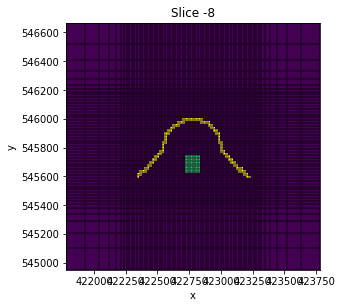

In [3]:
fig, axs = plt.figure(figsize=(10,10)), plt.subplot(2,2,1)
mesh.plotSlice(model, ind = -8, normal='Z', ax=axs, grid=True)

In [4]:
# No topography in this case, all active
actv = np.ones(mesh.nC, dtype='bool')

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = int(mesh.nC))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, actInd = actv, parallelized=True)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
data = prob.fields(model)

Begin forward: M=H0, Rx type= tmi


Text(0.5,1,'Noise')

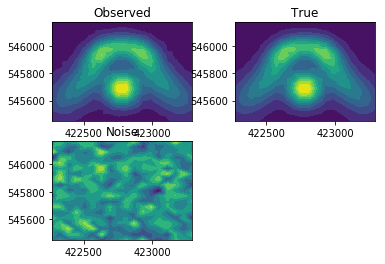

In [5]:
# Plot the forward simulation
xyzLoc = survey.srcField.rxList[0].locs

ax1 = plt.subplot(2,2,1)
Utils.plot2Ddata(xyzLoc, survey.dobs, ax=ax1)
plt.title('Observed')

ax2 = plt.subplot(2,2,2)
Utils.plot2Ddata(xyzLoc, data, ax=ax2)
plt.title('True')

ax3 = plt.subplot(2,2,3)
Utils.plot2Ddata(xyzLoc, survey.dobs-data, ax=ax3)
plt.title('Noise')

Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [7]:
# Starting model
m0 = np.ones(mesh.nC) * 1e-4

# Misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Create distance weights
wr = prob.getJtJdiag(m0, W=dmis.W)
wr = (wr/np.max(wr))
wr = wr**0.5

reg = Regularization.Sparse(
    mesh, indActive = actv, mapping = idenMap,
    cell_weights = wr
)

reg.norms = np.c_[0, 2, 2, 2] #<-- Change the norms here [ps, px, py, pz]
reg.mref = np.zeros(mesh.nC)

opt = Optimization.ProjectedGNCG(maxIter=40, lower=0., upper=10.,
                                     maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Apply Directives to the inversion
IRLS = Directives.Update_IRLS(
    f_min_change=1e-3, minGNiter=1, maxIRLSiter=20
)
saveOutput = Directives.SaveOutputEveryIteration(save_txt=False)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[
                                  betaest, IRLS, 
                                  update_Jacobi,
                                  saveOutput
                              ]
                            )

# Run the inversion
mrec = inv.run(m0)



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.38e+08  3.58e+04  1.35e-05  3.90e+04    1.90e+03      0              
   1  1.19e+08  2.88e+04  1.66e-05  3.08e+04    2.20e+03      0              
   2  5.95e+07  2.29e+04  5.22e-05  2.60e+04    2.15e+03      0   Skip BFGS  
   3  2.97e+07  1.67e+04  1.28e-04  2.05e+04    2.09e+03      0   Skip BFGS  
   4  1.49e+07  1.10e+04  2.63e-04  1.50e+04    2.03e+03      0   Skip BFGS  
   5  7.43e+06  6.65e+03  4.73e-04  1.02e+04    1.96e+03      0   Skip BFGS  
   6  3.72e+06  3.50e+03  7.69e-04  6.35e+03   

# Some plotting functions

In [8]:
from SimPEG.Utils import mkvc
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, actv=None, contours=None, fill=True,
                      orientation='vertical', cmap='Pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m[np.isnan(m)!=True].min()

    if vmax is None:
        vmax = m[np.isnan(m)!=True].max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = m[2*nC:]

        if actv is not None:
            m_lpx[actv!=True] = np.nan
            m_lpy[actv!=True] = np.nan
            m_lpz[actv!=True] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:

        if actv is not None:
            m[actv!=True] = np.nan

        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':

        if actv is not None:
            actIndFull = np.zeros(mesh.nC, dtype=bool)
            actIndFull[actv] = True
        else:
            actIndFull = np.ones(mesh.nC, dtype=bool)

        actIndFull = actIndFull.reshape(mesh.vnC, order='F')

        model = np.zeros((mesh.nCx, mesh.nCy))
        mx = np.zeros((mesh.nCx, mesh.nCy))
        my = np.zeros((mesh.nCx, mesh.nCy))
        for ii in range(mesh.nCx):
            for jj in range(mesh.nCy):

                zcol = actIndFull[ii, jj, :]
                model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]

                if len(m) == 3*nC:
                    mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                    my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = model.T
        
        amp = np.kron(np.ones(mesh.nCz), mkvc(model.T))
        if len(m) == 3*nC:
            mx = mx[::subFact, ::subFact].T
            my = my[::subFact, ::subFact].T

    im2, cbar = [], []
    if fill:
#         im2 = axs.contourf(xx, yy, model,
#                            30, vmin=vmin, vmax=vmax,
#                            cmap=cmap)

        im2 = mesh.plotSlice(mkvc(amp), ind=ind, normal=normal.upper(), ax=axs, clim=[vmin, vmax],
                             pcolorOpts={'clim':[vmin, vmax] ,'cmap':cmap})

        cbar = plt.colorbar(im2[0], orientation=orientation, ax=axs,
                 ticks=np.linspace(vmin, vmax, 4),
                 format="${%.3f}$", shrink=0.5)

    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:

        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar

def plot3Panels(mplot, fileName ,cmap = 'Pink_r', subFact=None, scale=None, vmin=None, vmax=None, color=np.r_[1,1,1,1]):

    fig = plt.figure(figsize=(14,8))

    indz = 8
    indy = int(mesh.nCy/2)-6
    indx = int(mesh.nCx/2)

    xlim = [422050, 423500]
    ylim = [545150, 546450]
    zlim = [1200, 1700]

    x = [422250, 422750, 423250]
    y = [545250, 545750, 546250]
    z = [1300, 1450, 1600]

#     axs = plt.subplot(2,1,2)

    axs = plt.subplot(1,2,1)
    axs, im, cbar = plotModelSections(mesh, mplot, actv = actv, normal='z',subFact=subFact, scale=scale, ind=indz, cmap=cmap, axs=axs,xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
    plotModelSections(mesh, model,normal='z',actv = actv, ind=indz,subFact=subFact, scale=scale, cmap=cmap, contours=[0.02], axs=axs,xlim=xlim, ylim=ylim, fill=False)

    # plotTopo(topo, axs=axs, fill=False)
#     plotMarkers(pts, azm, dip, ms = 50, color=color)
    # plt.scatter(survey.srcField.rxList[0].locs[:,0],survey.srcField.rxList[0].locs[:,1], 5, color='k')

    cbar.remove()
    plt.plot(xlim, [mesh.vectorCCy[int(indy)], mesh.vectorCCy[int(indy)]], c='k', linestyle='--')
    plt.text(xlim[0],mesh.vectorCCy[int(indy)],'A', fontsize = 16)
    plt.text(xlim[1],mesh.vectorCCy[int(indy)],"A'", fontsize = 16, ha = 'right')
    plt.plot([mesh.vectorCCx[int(indx)], mesh.vectorCCx[int(indx)]], ylim, c='k', linestyle='--')
    plt.text(mesh.vectorCCx[int(indx)], ylim[0],'B', fontsize = 16)
    plt.text(mesh.vectorCCx[int(indx)], ylim[1],"B'", fontsize = 16, va = 'top')
    
    # Plot fold axis
#     plt.plot(foldVec[:,0], foldVec[:,1], ylim, c='r', linestyle='-.')
    
    axs.set_xticks(list(map(int, x)))
    axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
    axs.set_xlabel('Easting (m)', size=12)

    axs.set_yticks(list(map(int, y)))
    axs.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
    axs.set_ylabel('Northing (m)', size=12)
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0-0.05,  pos.width*1.3, pos.height*1.3])
    axs.set_title('Plan View', fontsize=14)

    # EW PROFILE #
    axs = plt.subplot(2,2,2)
    axs, im, cbar = plotModelSections(mesh, mplot, normal='y', actv = actv,subFact=subFact, scale=scale, ind=indy, cmap=cmap, axs=axs,xlim=xlim, ylim=zlim, vmin=vmin, vmax=vmax)
    plotModelSections(mesh, model,normal='y', actv = actv, ind=indy,subFact=subFact, scale=scale, cmap=cmap, contours=[0.02], axs=axs,xlim=xlim, ylim=zlim, fill=False)
    
    plt.plot(np.r_[mesh.vectorCCx[indx], mesh.vectorCCx[indx]], zlim, 'k--')
    plt.text(mesh.vectorCCx[indx], zlim[1],"B-B'", va='bottom', ha='center')

    cbar.remove()
    axs.set_xlabel('Easting (m)', size=12)
    axs.set_xticks(list(map(int, x)))
    axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')

    axs.set_ylabel('Elevation (m)', size=12)
    axs.set_yticks(list(map(int, z)))
    axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0,  pos.width*1.25, pos.height*1.25])
    axs.set_title('A',loc='left', fontsize=14)
    axs.set_title("A'",loc='right', fontsize=14)
    axs.set_title("",loc='center', fontsize=14)


    # NS PROFILE #
    axs = plt.subplot(2,2,4)

    axs, im, cbar = plotModelSections(mesh, mplot, normal='x', actv = actv, ind=indx, cmap=cmap,subFact=subFact, scale=scale, axs=axs,xlim=ylim, ylim=zlim, vmin=vmin, vmax=vmax)
    plotModelSections(mesh, model,normal='x',actv = actv, ind=indx,subFact=subFact, scale=scale, cmap=cmap, contours=[0.02], axs=axs,xlim=ylim, ylim=zlim, fill=False)
#     plotModelSections(mesh, mkvc(rz1), normal='x', ind=indx,subFact=4, scale=7., cmap=cmap, axs=axs, vmin=0. ,vmax=0.1, fill=False)

#     plotModelSections(mesh, mkvc(mout), normal='x', ind=indx,subFact=4, scale=7., cmap=cmap, axs=axs,xlim=[422000,423500], ylim=[1200,1700], vmin=0. ,vmax=0.1, fill=False)

    plt.plot(np.r_[mesh.vectorCCy[indy], mesh.vectorCCy[indy]], zlim, 'k--')
    plt.text(mesh.vectorCCy[indy], zlim[1],"A-A'", va='bottom', ha='center')
#     plotProfile(topo, [mesh.vectorCCx[int(indx)],ylim[0]], [mesh.vectorCCx[int(indx)],ylim[1]],
#                              50, ax=axs, fig=fig, coordinate_system = 'yProfile',
#                              plotStr='k')
    
#     plotProfile(topodrapped, [mesh.vectorCCx[int(indx)],ylim[0]], [mesh.vectorCCx[int(indx)],ylim[1]],
#                              50, ax=axs, fig=fig, coordinate_system = 'yProfile',
#                              plotStr='k--')

#     plotProfile(survey.srcField.rxList[0].locs, [mesh.vectorCCx[int(indx)],ylim[0]], [mesh.vectorCCx[int(indx)],ylim[1]],
#                              18, ax=axs, fig=fig, coordinate_system = 'yProfile',
#                              plotStr='k.')
    # Plot fold axis
#     plt.plot(foldVec[:,1], foldVec[:,2], ylim, c='r', linestyle='-.')

    cbar.remove()
    axs.set_xlabel('Northing (m)', size=12)
    axs.set_xticks(list(map(int, y)))
    axs.set_xticklabels(map(str, map(int, y)),size=12, ha='center')

    axs.set_ylabel('Elevation (m)', size=12)
    axs.set_yticks(list(map(int, z)))
    axs.set_yticklabels(map(str, map(int, z)),size=12, rotation=90, va='center')
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0+0.1,  pos.width*1.25, pos.height*1.25])
    axs.set_title('B',loc='left', fontsize=14)
    axs.set_title("B'",loc='right', fontsize=14)
    axs.set_title("",loc='center', fontsize=14)

    axbar = plt.axes([pos.x0+0.065, pos.y0+0.075,  pos.width*.75, pos.height*.75])
    cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
    cbar.set_ticks(np.linspace(-.0,0.1,4))
    axbar.text(pos.x0+0.5, pos.y0-.45,'g/cc', size=14)
    axbar.axis('off')
    plt.savefig(fileName, bbox_inches='tight')

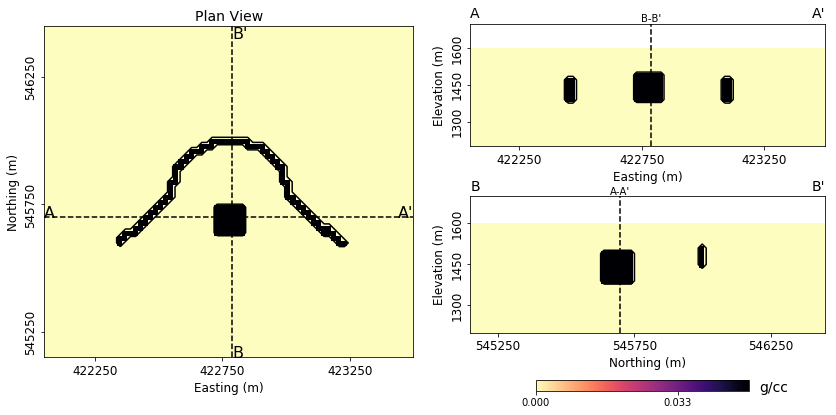

In [9]:
fileName = 'Synthetic_Model.png'
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
plot3Panels(model,fileName, vmin = -1e-5, vmax=0.05, cmap='magma_r')

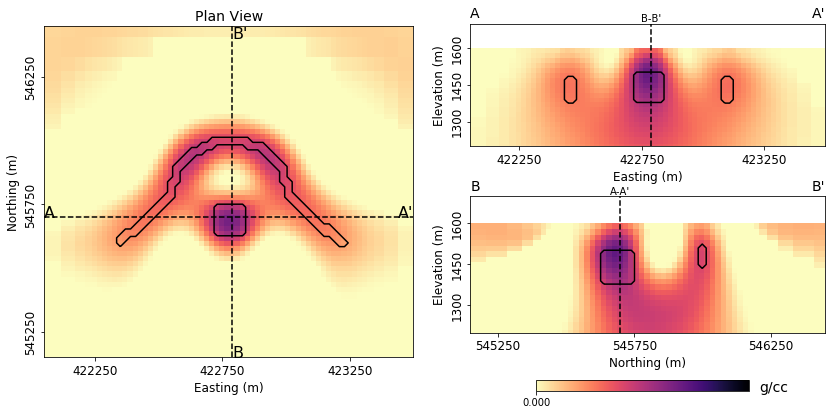

In [10]:
fileName = 'Recovered_Model_l2Norm.png'
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
plot3Panels(invProb.l2model,fileName, vmin = -1e-5, vmax=0.01, cmap='magma_r')

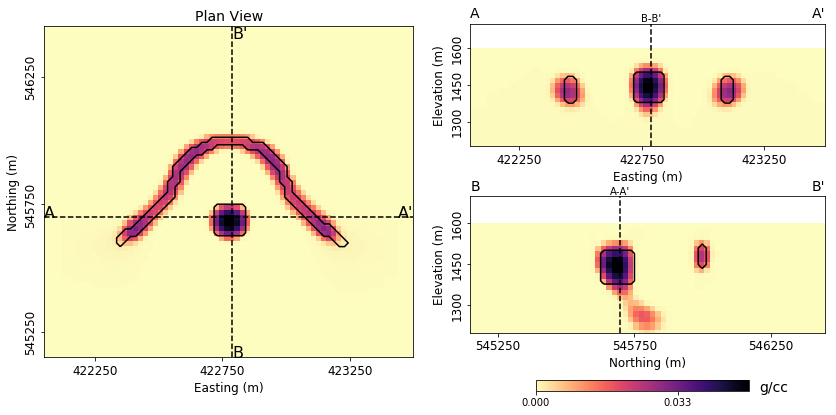

In [11]:
fileName = 'Recovered_Model_lpNorm.png'
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
plot3Panels(invProb.model,fileName, vmin = -1e-5, vmax=0.05, cmap='magma_r')

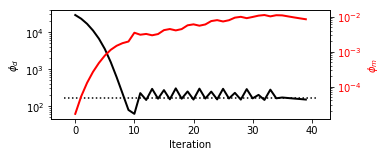

In [12]:
saveOutput.plot_misfit_curves()